In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from math import exp, sqrt,pi
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

from mpl_toolkits import mplot3d

In [2]:
epochs = 50

device = torch.device("cpu")

batchsize = 128 
learning_rate = 1e-3

eps = 1

start = 0.
end = 1.

x = np.linspace(start,end,100 )
y = np.linspace(start,end,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))


cos2pix = np.array([[math.cos(2*math.pi*ind[0])] for ind in x])
cos2piy = np.array([[math.cos(2*math.pi*ind[0])] for ind in y])
sinpix = np.array([[math.sin(math.pi*ind[0])] for ind in x])
sinpiy = np.array([[math.sin(math.pi*ind[0])] for ind in y])

soln = ((sinpix)**2) * ((sinpiy)**2)

f = 8*(eps**2)*((math.pi)**4)*(cos2pix*cos2piy - cos2pix*sinpiy*sinpiy - cos2piy*sinpix*sinpix) - 2*((math.pi)**2)*(cos2pix*sinpiy*sinpiy + cos2piy*sinpix*sinpix)

In [3]:

def train(device,x,y,f,eps,learning_rate,epochs):
	xnet = torch.Tensor(x)#.to(device)
	ynet = torch.Tensor(y)#.to(device) 
	fnet = torch.Tensor(f)#.to(device) 

	h_n = 128
	input_n = 2  
	class Swish(nn.Module):
		def __init__(self, inplace=True):
			super(Swish, self).__init__()
			self.inplace = inplace

		def forward(self, x):
			if self.inplace:
				x.mul_(torch.sigmoid(x))
				return x
			else:
				return x * torch.sigmoid(x)
	

	class Net(nn.Module):
		def __init__(self):
			super(Net, self).__init__()
			self.tanh = nn.Tanh()
			self.lin0 = nn.Linear(input_n,h_n)
			self.lin = nn.Linear(h_n,h_n)
			self.lin1 = nn.Linear(h_n,1)
			self.swish = Swish()
		def forward(self,x):		
			tanh1 = self.tanh(x)
			tanh2 = self.tanh(1 - x)
			tanh11 = (tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))*(tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))
			tanh22 = (tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))*(tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))
			x = self.lin0(x)
			x = self.swish(x)
			x = self.lin(x)
			x = self.swish(x)
			x = self.lin(x)
			x = self.swish(x)
			x = self.lin(x)
			x = self.swish(x)
			x = self.lin(x)
			x = self.swish(x)
			x = self.lin(x)
			x = self.swish(x)
			x = self.lin(x)
			x = self.swish(x)
			x = self.lin1(x)
			out = x*tanh11*tanh22
			return  out

	
	net = Net()#.to(device)
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	net.apply(init_normal)

	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(xnet,ynet,f):
		xnet.requires_grad = True
		ynet.requires_grad = True
		points = torch.cat((xnet,ynet),1) 
		U = net(points)
		U = U.view(len(U),-1)
		U_x = torch.autograd.grad(U,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxx = torch.autograd.grad(U_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxxx = torch.autograd.grad(U_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyy = torch.autograd.grad(U_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyyy = torch.autograd.grad(U_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxy = torch.autograd.grad(U_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxyy = torch.autograd.grad(U_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		loss1 = (eps**2)*(U_xxxx + U_yyyy + 2*U_xxyy) - (U_xx + U_yy) - f 
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	def plot_net():
		points = torch.cat((xnet,ynet),1)
		U = net(points)
		z = U.detach().numpy()
		
		x = np.linspace(0.,1.,100);y = np.linspace(0.,1.,100)
		x,y = np.meshgrid(x,y)
		fig = plt.figure()
		ax = plt.axes(projection='3d')
		ax.plot_surface(x,y,z.reshape(100,100))
		plt.show()

	losses = []
	tic = time.time()

	xx = np.linspace(0.,1.,100);yy = np.linspace(0.,1.,100)
	xx,yy = np.meshgrid(xx,yy)

	for epoch in range(epochs):
		if epoch == 50:
			learning_rate = 0.0001
			new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
			optimizer = new_optimizer
		
		net.zero_grad()
		loss = Loss_criterion(xnet,ynet,fnet)
		loss.backward()
			
		optimizer.step() 
		points = torch.cat((xnet,ynet),1)
		U = net(points)
		z = U.detach().numpy()
		actual_loss = np.square(soln - z).mean()
		if epoch % 5 == 0:
			ax = plt.axes(projection='3d')
			ax.plot_surface(xx,yy,z.reshape(100,100))
			plt.show()
		print('Train Epoch: {} \nLoss: {:.10f} \tActual loss: {:.6f}'.format(
			epoch, loss.item(),actual_loss))
		losses.append([loss.item(),loss.item()])

	toc = time.time()
	elapseTime = toc - tic
	print ("elapse time in parallel = ", elapseTime)

	net_in = torch.cat((xnet,ynet),1)
	output = net(net_in)  
	
	return output 


output = train(device,x,y,f,eps,learning_rate,epochs)



C:\Users\bsaty\AppData\Local\Temp\ipykernel_28520\649682639.py:29: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.lin.weight)
C:\Users\bsaty\AppData\Local\Temp\ipykernel_28520\649682639.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.lin0.weight)
C:\Users\bsaty\AppData\Local\Temp\ipykernel_28520\649682639.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.lin1.weight)


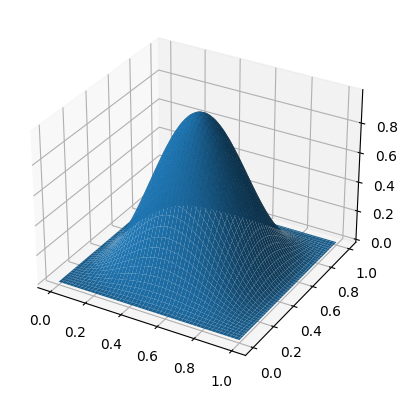

In [19]:
x = np.linspace(0.,1.,100);y = np.linspace(0.,1.,100)
x,y = np.meshgrid(x,y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x,y,soln.reshape(100,100))
plt.show()